<h1>
    Demo
</h1>

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.fourier import circuit_spectrum
from lecture08_helpers import *

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

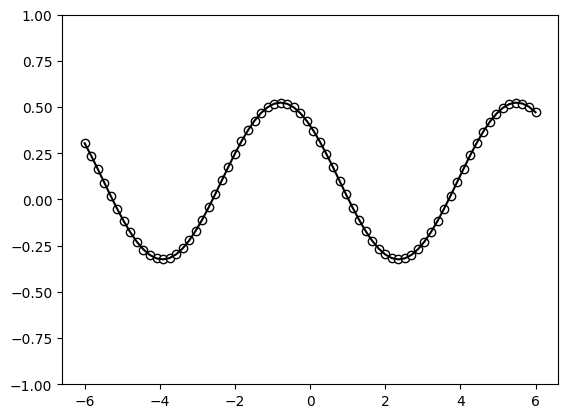

In [3]:
# This part of the code prints the graph we are trying to approximate

degree = 1  # degree of the target function
scaling = 1  # scaling of the data
coeffs = [0.15 + 0.15j]*degree  # coefficients of non-zero frequencies
coeff0 = 0.1  # coefficient of zero frequency

def target_function(x):
    """Generate a truncated Fourier series, where the data gets re-scaled."""
    res = coeff0
    for idx, coeff in enumerate(coeffs):
        exponent = np.complex128(scaling * (idx+1) * x * 1j)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res)

x = np.linspace(-6, 6, 70)
target_y = np.array([target_function(x_) for x_ in x])


plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-1, 1)
plt.show()

In [4]:
#This is a VQC that changes based on the input n_layers which changes how many frequencies we can sample.

import pennylane as qml
import numpy as np

n_layers = 2
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def circuit(x, weights):
    for l in range(n_layers):
        qml.RX(x, wires=0, id="x"+str(0))
        qml.Rot(weights[l,0,0], weights[l,0,1], weights[l,0,2], wires=0)
    qml.RZ(x, wires=0, id="x0")
    return qml.expval(qml.PauliZ(wires=0))

x = 1
weights = np.random.random((n_layers, 1, 3))
res = qml.fourier.circuit_spectrum(circuit)(x, weights)

print(qml.draw(circuit)(x, weights))
for inp, freqs in res.items():
    print(f"{inp}: {freqs}")

0: ──RX(1.00)──Rot(0.49,0.56,0.82)──RX(1.00)──Rot(0.35,0.03,0.58)──RZ(1.00)─┤  <Z>
x0: [-3.0, -2.0, -1.0, 0, 1.0, 2.0, 3.0]


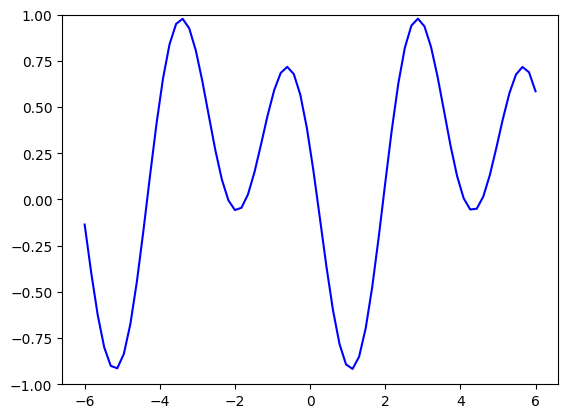

In [9]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.fourier import circuit_spectrum
from lecture08_helpers import *

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

r = 1 # number of times the encoding gets repeated (here equal to the number of layers)
weights = np.random.random((n_layers, 1, 3), requires_grad=True) # some random initial weights

x = np.linspace(-6, 6, 70)
# x = np.linspace(-6, 6, 10, requires_grad=False)
random_quantum_model_y = [circuit(x_, weights) for x_ in x]

plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show()

In [10]:
np.random.seed(42)

def square_loss(targets, predictions):
    loss = 0
    for t, p in zip(targets, predictions):
        loss += (t - p) ** 2
    loss = loss / len(targets)
    return 0.5*loss

def cost(weights, x, y):
    predictions = [circuit(x_, weights) for x_ in x]
    return square_loss(y, predictions)

max_steps = 50
opt = qml.AdamOptimizer(0.3)
batch_size = 25
cst = [cost(weights, x, target_y)]  # initial cost

for step in range(max_steps):

    # Select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    # Update the weights by one optimizer step
    weights, _, _ = opt.step(cost, weights, x_batch, y_batch)

    # Save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

Cost at step  10: 0.03648780136353204
Cost at step  20: 0.009179193735756793
Cost at step  30: 0.003169695483356557
Cost at step  40: 0.0015819344498022947
Cost at step  50: 0.0006028838235252727


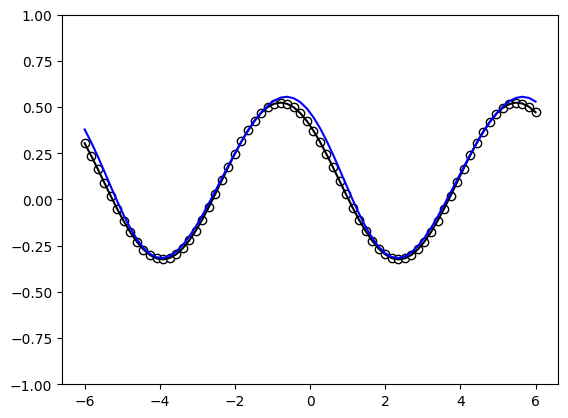

In [11]:
predictions = [circuit(x_, weights) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue')
plt.ylim(-1,1)
plt.show()

In [5]:
#The gates are RX but you are trying to diagonalize Paulix and Pauliz
def encoding_eigvals(x):
    rxEigvalOne = qml.eigvals(qml.PauliX(wires=0))/2
    rxEigvalTwo = qml.eigvals(qml.PauliX(wires=0))/2
    rzEigval = qml.eigvals(qml.PauliZ(wires=0))/2
    
    return rxEigvalOne, rxEigvalTwo, rzEigval

x = 1
rxEigvalOne, rxEigvalTwo, rzEigval = encoding_eigvals(x)

#Create an array of all possible combinations of the eigenvalues
upperCaseLambdaArray = []
for eigValOne in rxEigvalOne:
    for eigValTwo in rxEigvalTwo:
        for eigValThree in rzEigval:
            upperCaseLambdaArray.append(eigValOne+eigValTwo+eigValThree)

#Create an array of all possible frequency values stored in OmegaArray
OmegaArray = []
for upperCaseLambdai in upperCaseLambdaArray:
    for upperCaseLambdaj in upperCaseLambdaArray:
        OmegaArray.append(upperCaseLambdai-upperCaseLambdaj)

#Create an new array of unique frequency values stored in OmegaArray
OmegaArray = np.unique(OmegaArray)

print(OmegaArray)

[-3. -2. -1.  0.  1.  2.  3.]


In [6]:
#Helper function to create a range of floats for Algorithm 3
def range_with_floats(start, stop, step):
    while stop >= start:
        yield start
        start += step

#Algorithim 3
#Number of layers
n_layers = 2

#For the circuit we use with each algorithm the number of encoding gates is number of layers + 1
#This is because we have one additional encoding gate RZ.
numberOfEncodingGates = n_layers + 1

#Because the eigenvalues of PauliX and PauliZ gates are -0.5 and 0.5 we know that w_max is numberOfEncodingGates
wMax = numberOfEncodingGates

#We need to assign a step value a resonable step value is anywhere from 0 to 1
step = 1

grid = []

#Create the grid
for i in range_with_floats(0, wMax, step):
    grid.append(i)

print(grid)


[0, 1, 2, 3]


In [7]:
def construct_phi(x, frequencies):
  #constructs phi or tilde_phi 
  #based on x and the given frequencies

  phi = np.zeros(2* len(frequencies))
  for i in range(len(frequencies)):
    phi[2*i] = np.cos(frequencies[i] * x)
    phi[2*i+1] = np.sin(frequencies[i] * x)
  
  return phi

def construct_Phi(xi_array, frequencies):
  M = len(xi_array)
  P = 2*len(frequencies)
  Phi = np.zeros((M, P))

  for i in range(M):
    phi = construct_phi(xi_array[i], frequencies)
    for j in range(P):
      Phi[i][j] = phi[j]
  return Phi

def construct_w(xi_array, yi_array, frequencies):
  M = len(xi_array)
  P = 2*len(frequencies)
  Phi = construct_Phi(xi_array, frequencies)
  lambda_hyper = 0.001

  Phi_T = np.transpose(Phi)

  w_1 = np.matmul(Phi_T, Phi) + M*lambda_hyper * np.identity(P)
  w_2 = np.matmul(np.linalg.inv(w_1), Phi_T)
  w = np.matmul(w_2, yi_array)
  return w

def f(x, w, frequencies):
  phi = construct_phi(x, frequencies)
  return np.matmul(w, phi)

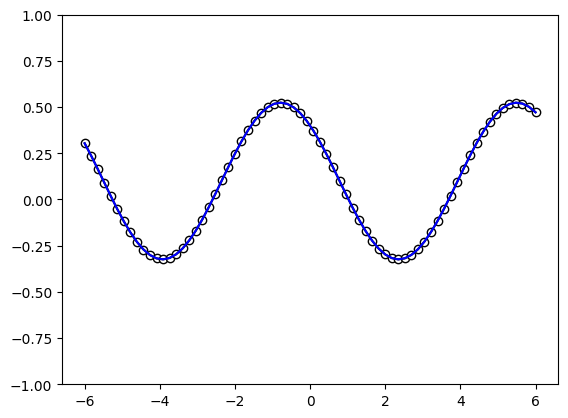

In [8]:
degree = 1  # degree of the target function
scaling = 1  # scaling of the data
coeffs = [0.15 + 0.15j]*degree  # coefficients of non-zero frequencies
coeff0 = 0.1  # coefficient of zero frequency

def target_function(x):
    """Generate a truncated Fourier series, where the data gets re-scaled."""
    res = coeff0
    for idx, coeff in enumerate(coeffs):
        exponent = np.complex128(scaling * (idx+1) * x * 1j)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res)

x = np.linspace(-6, 6, 70)
target_y = np.array([target_function(x_) for x_ in x])

frequencies = OmegaArray
xi_array = x
yi_array = target_y
w = construct_w(xi_array, yi_array, frequencies)

target_y_f = np.array([f(x_, w, frequencies) for x_ in x])

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-1, 1)

plt.plot(x, target_y_f, c='blue')
plt.show()